In [1]:
import os
print(os.listdir("../input/dog-breed-identification"))

['sample_submission.csv', 'test', 'train', 'labels.csv']


In [2]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import datetime
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# loading data
labels_df = pd.read_csv('../input/dog-breed-identification/labels.csv')
print(labels_df[:5])
tests_df = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')
print(tests_df[:5])

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  

In [4]:
labels_df['id'] = labels_df['id'] + '.jpg'
tests_df['id'] = tests_df['id'] + '.jpg'

In [5]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [6]:
tests_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


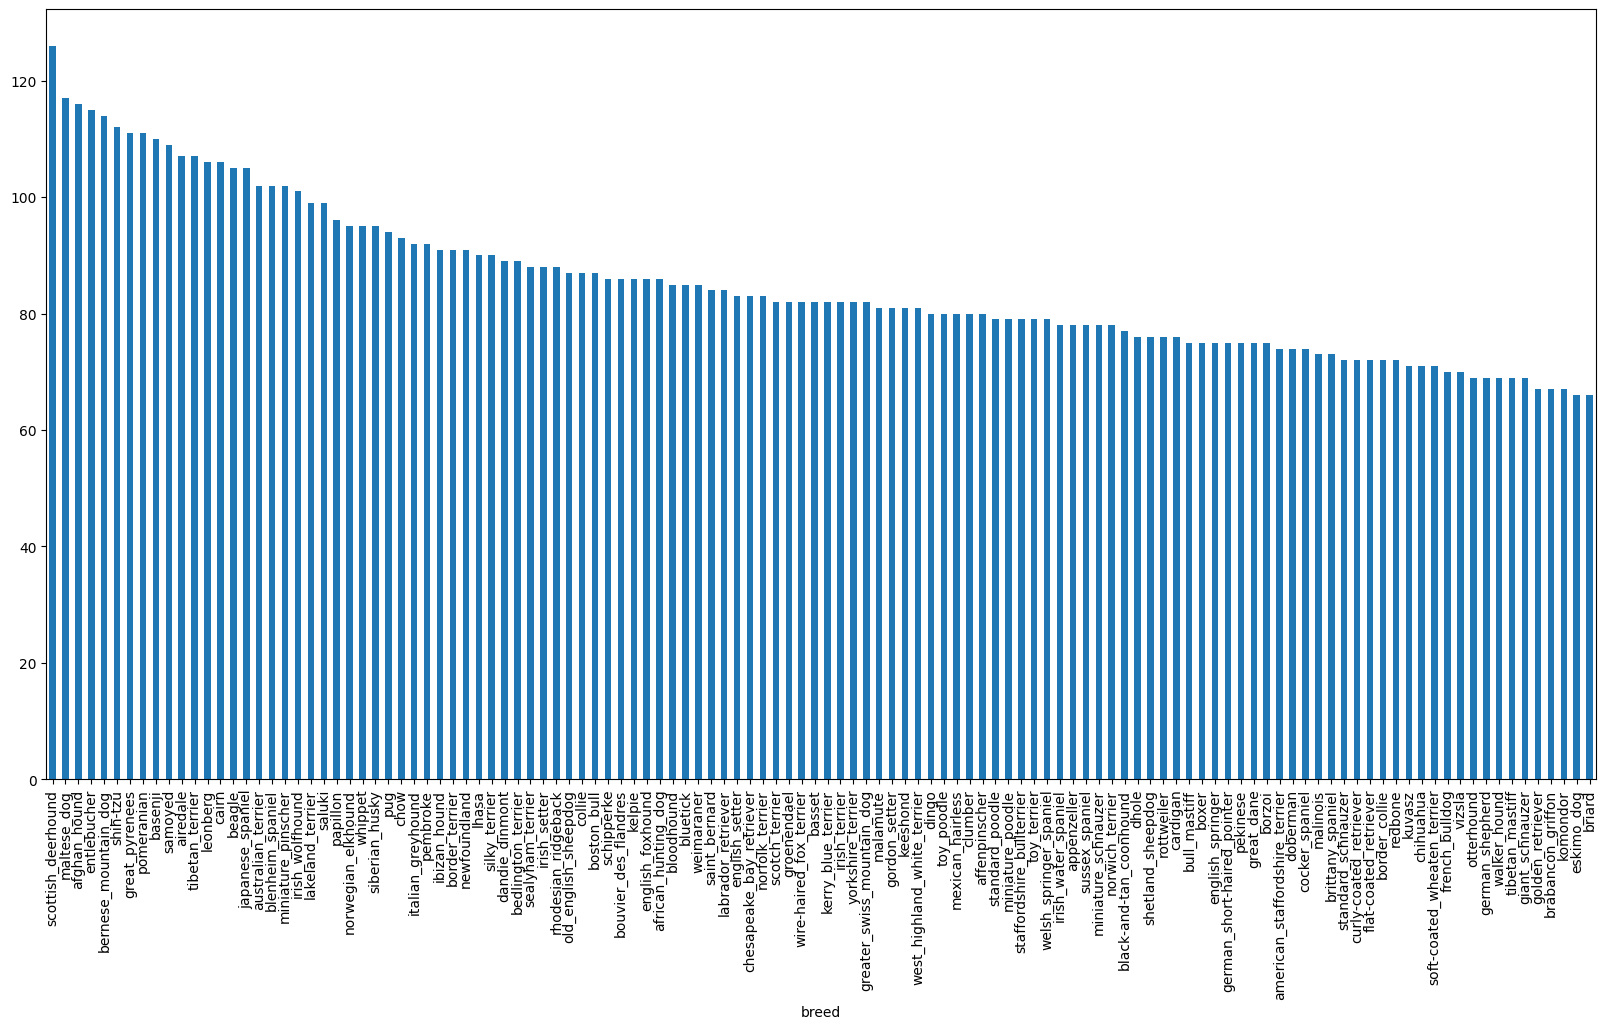

In [7]:
# Number of images are there of each breed?
labels_df["breed"].value_counts().plot.bar(figsize=(20, 10));

In [8]:
# create a label in numpy array
labels = labels_df["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [9]:
# create the unique breeds 
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [10]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

### Preprocessing Images

In [11]:
IMG_SIZE = 299

In [12]:
train_datagen_augmented = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             validation_split = 0.2)
train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,)

In [13]:
train_generator=train_datagen.flow_from_dataframe(dataframe=labels_df,
                                                    directory="../input/dog-breed-identification/train",
                                                    x_col="id", y_col="breed",
                                                    batch_size=32,
                                                    seed=2023,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    target_size=(IMG_SIZE, IMG_SIZE))

train_generator_augmented=train_datagen_augmented.flow_from_dataframe(dataframe=labels_df,
                                                            directory="../input/dog-breed-identification/train",
                                                            x_col="id", y_col="breed",
                                                            subset="training",
                                                            batch_size=32,
                                                            seed=2023,
                                                            shuffle=True,
                                                            class_mode="categorical",
                                                            target_size=(IMG_SIZE, IMG_SIZE))
valid_generator=train_datagen_augmented.flow_from_dataframe(dataframe=labels_df,
                                                            directory="/kaggle/input/dog-breed-identification/train",
                                                            x_col="id", y_col="breed",
                                                            subset="validation",
                                                            batch_size=32,
                                                            seed=2023,
                                                            shuffle=False,
                                                            class_mode="categorical",
                                                            target_size=(IMG_SIZE, IMG_SIZE))

test_generator=test_datagen.flow_from_dataframe(dataframe=tests_df,
                                                directory="../input/dog-breed-identification/test",
                                                x_col="id", y_col=None,
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE, IMG_SIZE))

Found 10222 validated image filenames belonging to 120 classes.
Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames.


In [14]:
images, labels = train_generator.next()

In [15]:
augmented_images, augmented_labels = train_generator_augmented.next()

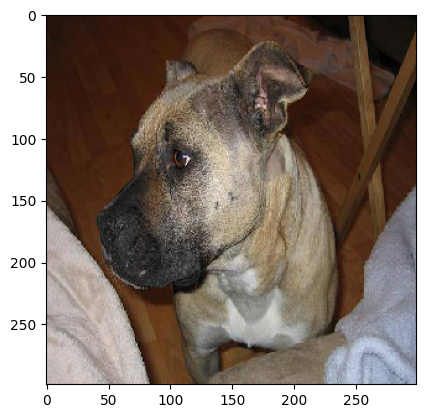

In [16]:
plt.imshow(images[1])

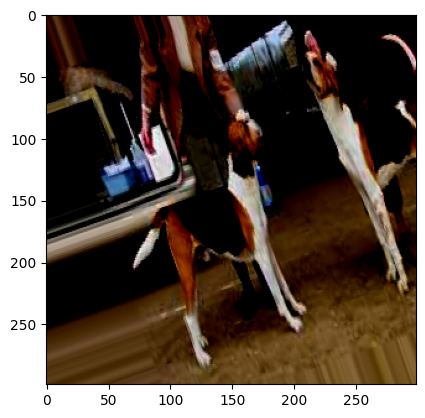

In [17]:
plt.imshow(augmented_images[1])

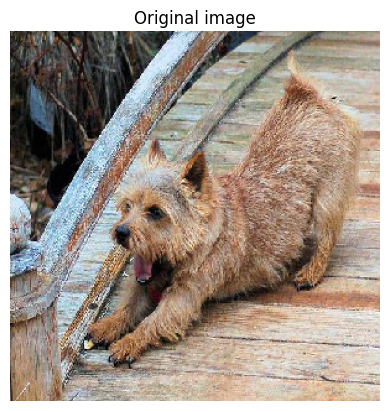

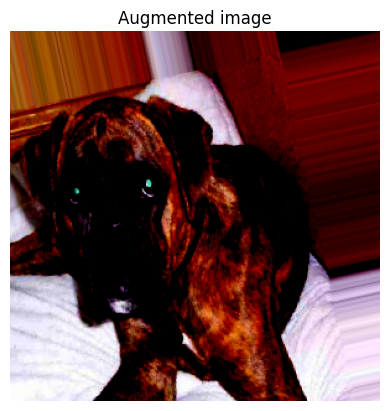

In [18]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [19]:
# Building the Model
model = Sequential()
model.add(InceptionResNetV2(include_top=False,
                            pooling='avg',
                            weights='imagenet'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Dense(120, activation='softmax'))
model.layers[0].trainable=False
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 1s 0us/step


In [20]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("../output",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [21]:
# Create new TensorBoard session everytime we train a model
tensorboard = create_tensorboard_callback()

In [22]:
model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [23]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,
                    validation_steps=int(0.25 * len(train_generator)),
                    epochs=100,
                    callbacks=[tensorboard, model_early_stopping])

Epoch 1/100
320/320 [==============================] - 190s 527ms/step - loss: 1.8340 - accuracy: 0.6102 - val_loss: 0.3988 - val_accuracy: 0.8748
Epoch 2/100
320/320 [==============================] - 101s 315ms/step - loss: 0.7402 - accuracy: 0.8148
Epoch 3/100
320/320 [==============================] - 101s 314ms/step - loss: 0.6490 - accuracy: 0.8357
Epoch 4/100
320/320 [==============================] - 100s 313ms/step - loss: 0.5946 - accuracy: 0.8485
Epoch 5/100
320/320 [==============================] - 101s 314ms/step - loss: 0.5866 - accuracy: 0.8441
Epoch 6/100
320/320 [==============================] - 101s 314ms/step - loss: 0.5716 - accuracy: 0.8497
Epoch 7/100
320/320 [==============================] - 100s 313ms/step - loss: 0.5575 - accuracy: 0.8513
Epoch 8/100
320/320 [==============================] - 100s 313ms/step - loss: 0.5344 - accuracy: 0.8563
Epoch 9/100
320/320 [==============================] - 100s 312ms/step - loss: 0.5322 - accuracy: 0.8581
Epoch 10/100


In [24]:
# save model
model.save('my_model.h5')

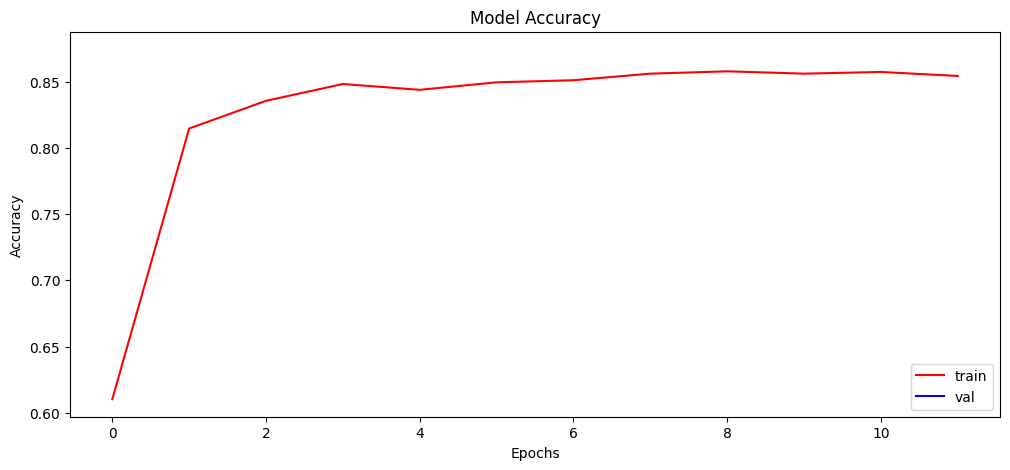

In [25]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [26]:
y_pred = model.predict(test_generator, verbose=1)

10357/10357 [==============================] - 240s 23ms/step


In [30]:
y_pred.shape

(10357, 120)

In [ ]:
y_true = test_generator.classes

In [29]:
# Load the TensorFlow model.
model = tf.keras.models.load_model('my_model.h5')

# Convert the TensorFlow model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model.
with open('my_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

In [59]:
labels = (train_generator_augmented.class_indices)
labels = list(labels.keys())
df = pd.DataFrame(data=y_pred,
                  columns=labels)

columns = list(df)
columns.sort()
df = df.reindex(columns=columns)
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.272432e-10,3.022260e-13,9.851701e-12,1.173015e-11,4.209088e-10,2.387253e-11,3.310706e-12,1.745828e-12,7.977534e-14,3.311464e-12,...,5.254393e-11,4.148356e-10,3.190867e-11,2.189548e-10,3.600011e-10,4.232824e-13,3.184338e-11,2.126081e-09,6.236430e-10,2.816710e-11
1,5.672231e-12,1.202432e-11,8.041913e-13,1.925722e-11,2.264139e-11,4.795536e-10,9.777738e-11,4.182461e-10,8.612027e-13,4.739148e-11,...,4.474784e-10,2.544482e-10,1.056799e-09,3.142119e-09,2.870374e-11,6.112882e-12,6.111029e-08,3.024731e-10,4.599214e-11,1.287484e-11
2,2.776268e-11,3.095899e-11,1.822778e-11,4.020821e-11,2.035618e-11,1.725166e-08,1.581601e-12,1.025222e-11,5.062402e-10,1.077527e-10,...,1.357990e-09,2.504035e-10,2.728536e-09,2.308072e-09,1.232768e-10,7.200235e-09,8.496722e-10,2.839838e-09,3.893765e-10,6.230323e-12
3,1.855016e-08,1.189077e-14,3.782716e-13,2.738813e-12,1.733150e-12,4.417105e-10,2.734901e-10,2.664006e-10,2.961781e-12,5.320751e-11,...,1.273379e-09,4.246444e-11,5.536904e-12,8.724330e-11,1.788168e-10,4.841568e-11,5.116496e-11,2.238805e-09,5.920340e-14,7.378742e-10
4,3.691330e-05,1.079276e-08,7.797408e-09,2.540818e-09,1.163666e-09,3.381903e-07,1.746987e-08,5.422394e-08,1.416676e-08,1.954146e-08,...,4.743499e-08,5.837305e-09,3.037046e-10,1.528079e-07,1.682632e-09,3.657898e-09,3.880297e-09,1.383113e-07,4.032177e-09,4.001816e-08


In [60]:
len(df)

10357

In [61]:
sample_df=pd.read_csv('../input/dog-breed-identification/sample_submission.csv')
sample_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [62]:
filenames = pd.DataFrame(pred_df['id'], columns=['id'])
filenames

,id
0,000621fb3cbb32d8935728e48679680e
1,00102ee9d8eb90812350685311fe5890
2,0012a730dfa437f5f3613fb75efcd4ce
3,001510bc8570bbeee98c8d80c8a95ec1
4,001a5f3114548acdefa3d4da05474c2e
...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8
10353,fff1ec9e6e413275984966f745a313b0
10354,fff74b59b758bbbf13a5793182a9bbe4
10355,fff7d50d848e8014ac1e9172dc6762a3


In [63]:
preds_df = pd.concat([filenames, df], axis=1)

In [64]:
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.272432e-10,3.022260e-13,9.851701e-12,1.173015e-11,4.209088e-10,2.387253e-11,3.310706e-12,1.745828e-12,7.977534e-14,...,5.254393e-11,4.148356e-10,3.190867e-11,2.189548e-10,3.600011e-10,4.232824e-13,3.184338e-11,2.126081e-09,6.236430e-10,2.816710e-11
1,00102ee9d8eb90812350685311fe5890,5.672231e-12,1.202432e-11,8.041913e-13,1.925722e-11,2.264139e-11,4.795536e-10,9.777738e-11,4.182461e-10,8.612027e-13,...,4.474784e-10,2.544482e-10,1.056799e-09,3.142119e-09,2.870374e-11,6.112882e-12,6.111029e-08,3.024731e-10,4.599214e-11,1.287484e-11
2,0012a730dfa437f5f3613fb75efcd4ce,2.776268e-11,3.095899e-11,1.822778e-11,4.020821e-11,2.035618e-11,1.725166e-08,1.581601e-12,1.025222e-11,5.062402e-10,...,1.357990e-09,2.504035e-10,2.728536e-09,2.308072e-09,1.232768e-10,7.200235e-09,8.496722e-10,2.839838e-09,3.893765e-10,6.230323e-12
3,001510bc8570bbeee98c8d80c8a95ec1,1.855016e-08,1.189077e-14,3.782716e-13,2.738813e-12,1.733150e-12,4.417105e-10,2.734901e-10,2.664006e-10,2.961781e-12,...,1.273379e-09,4.246444e-11,5.536904e-12,8.724330e-11,1.788168e-10,4.841568e-11,5.116496e-11,2.238805e-09,5.920340e-14,7.378742e-10
4,001a5f3114548acdefa3d4da05474c2e,3.691330e-05,1.079276e-08,7.797408e-09,2.540818e-09,1.163666e-09,3.381903e-07,1.746987e-08,5.422394e-08,1.416676e-08,...,4.743499e-08,5.837305e-09,3.037046e-10,1.528079e-07,1.682632e-09,3.657898e-09,3.880297e-09,1.383113e-07,4.032177e-09,4.001816e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,5.162202e-08,1.611204e-06,3.797283e-08,2.395560e-07,4.130459e-08,5.742356e-08,6.454043e-07,2.168817e-07,4.493879e-08,...,4.005345e-04,1.307407e-07,6.961344e-08,4.490026e-07,2.123397e-07,1.922501e-06,6.095322e-09,1.110115e-06,1.634304e-08,1.882558e-08
10353,fff1ec9e6e413275984966f745a313b0,3.056910e-11,9.796839e-12,8.171888e-11,5.254617e-10,1.572226e-08,5.157347e-11,4.392820e-09,5.181531e-12,1.109476e-10,...,1.750076e-08,5.559388e-11,5.348674e-06,3.640418e-11,9.999899e-01,3.802922e-10,6.266727e-11,1.550977e-09,1.962859e-10,2.535963e-08
10354,fff74b59b758bbbf13a5793182a9bbe4,2.766239e-10,6.114361e-10,9.572128e-07,7.474020e-13,5.004071e-11,5.707145e-09,4.568395e-09,1.065151e-09,6.370129e-10,...,1.182252e-10,4.220996e-10,2.881071e-11,1.865888e-11,5.645479e-12,7.006532e-07,2.594183e-11,8.101728e-10,1.608948e-09,3.893295e-12
10355,fff7d50d848e8014ac1e9172dc6762a3,3.014904e-08,4.000772e-11,1.268033e-10,3.306743e-12,1.676666e-11,1.260395e-08,2.146277e-10,1.483691e-10,8.322901e-10,...,3.655834e-09,7.459202e-11,1.090819e-11,1.305803e-08,2.456572e-11,3.316012e-10,5.248157e-10,2.853876e-09,1.001805e-11,1.051694e-09


In [66]:
preds_df.to_csv("submission.csv",index=False)